In [1]:
import json, requests, os
import pandas as pd
import numpy as np
import itertools
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)

In [3]:
USER_NAME = "DECEIVERdeWISE"
LEAGUE_NAME = 'Degenerate Dynasty'
API_BASE = "https://api.sleeper.app/v1/"
YEAR = "2021"

In [4]:
[('Die Hard Dynasty', '709838602963587072'),
 ('The Black Hole of Free Time', '711050188327849984'),
 ('Footballholics Auctioneers', '693953665865719808'),
 ('Fantasy Football Junkies', '654119835697004544'),
 ('Jimmy Rustlers Anonymous', '650074922340679680')]

[('Die Hard Dynasty', '709838602963587072'),
 ('The Black Hole of Free Time', '711050188327849984'),
 ('Footballholics Auctioneers', '693953665865719808'),
 ('Fantasy Football Junkies', '654119835697004544'),
 ('Jimmy Rustlers Anonymous', '650074922340679680')]

In [5]:
def user_id(user_name):
    user_url = f"https://api.sleeper.app/v1/user/{user_name}"
    un_res = requests.get(user_url)
    user_id = un_res.json()['user_id']
    return user_id

In [6]:
def user_leagues(user_name:str, year= '2021') -> list:
    owner_id = user_id(user_name)
    leagues_url = f"https://api.sleeper.app/v1/user/{owner_id}/leagues/nfl/{year}"
    leagues_res = requests.get(leagues_url)
    LEAGUE_META = [(i['name'],i['league_id'] ) for i in leagues_res.json()]
    return LEAGUE_META

In [41]:
user_id('DECEIVERdeWISE')

'443562328634421248'

In [40]:
user_leagues('DECEIVERdeWISE')

[('Tidehunter Bestball Dynasty', '721195555044270080'),
 ('Startup Addiction Hotline Dynasty', '727715677737132032'),
 ('Dynasty Warriors', '727570013090832384'),
 ('One More Time Dynasty', '726209830309658624'),
 ('You Twisted My Arm Dynasty', '725221738849337344'),
 ('GOATS', '722698207649415168'),
 ('League of Apes', '725834216851480576'),
 ('Vermont State Highway Patrol', '724353672976355328'),
 ('DHenderson 4.12 ($100 SF TE prem)', '723607081281728512'),
 ('Cam Akers Memorial Dynasty', '723337196479799296'),
 ('Last One For Real Dynasty', '722595026743422976'),
 ('Degenerate Dynasty', '721719237760057344'),
 ('2021 Dynasty SuperFlex', '721112977687797760'),
 ('Rookie Monster!', '716848819651846144'),
 ('Dynasty Kings 2.0 ', '719353319016960000'),
 ('$200 SF/TE Prem Dynasty ', '720021564086644736'),
 ('League of Legends', '713409780139495424'),
 ('Rep Your City', '710313185541963776'),
 ('Die Hard Dynasty', '709838602963587072'),
 ('NFFDL', '695336126537363456'),
 ('LEGENDS NEVER D

In [7]:
def league_managers(league_str: str, user_name:str) -> list:
    managers = []
    for i in user_leagues(user_name):
        if i[0] in league_str:
            LEAGUE_ID = i[1]
            league_managers_url = f"https://api.sleeper.app/v1/league/{LEAGUE_ID}/users"
            managers_res = requests.get(league_managers_url)
            for i in managers_res.json():
                a1 = (i['user_id'],i['display_name'], i['league_id'])
                managers.append(a1)
    return managers

In [8]:
users_size = len(league_managers('Footballholics Auctioneers', USER_NAME))

In [9]:
all_players_df = pd.DataFrame() 

league_users =  [i[1] for i in league_managers(LEAGUE_NAME, USER_NAME)]

for user in league_users:
    owner_id = user_id(user)
    league_ids = user_leagues(user)
    
    LEAGUES = [i for i in league_ids]
    league_cnt = len(LEAGUES)
    
    for league in LEAGUES:

        rosters_url = f"https://api.sleeper.app/v1/league/{league[1]}/rosters"
        roster_res = requests.get(rosters_url)
        league_rosters = roster_res.json()
        
        for roster in league_rosters:
            if roster['owner_id'] == owner_id:
                roster.update({'league_id': league[1]})
                roster.update({'league_name': league[0]})
                players = roster['players']
                player_data = []
                if players:
                    for player in players:
                        player_tuple = (player, league[0], league[1], user, owner_id, league_cnt)
                        player_data.append(player_tuple)

                    player_df = pd.DataFrame(player_data, columns=['player_id', 'league_name', 'league_id', 'user_name', 'user_id', 'league_cnt'])
                    all_players_df = all_players_df.append(player_df,ignore_index=True)
ap_df = all_players_df.groupby(['player_id', 'user_name', 'user_id', 'league_cnt'],as_index = False).size()

In [10]:
df = pd.DataFrame() 

owner_id = user_id(USER_NAME)
league_ids = user_leagues(USER_NAME)

LEAGUES = [i for i in league_ids]
for league in LEAGUES:
    rosters_url = f"https://api.sleeper.app/v1/league/{league[1]}/rosters"
    roster_res = requests.get(rosters_url)
    league_rosters = roster_res.json()

    for roster in league_rosters:
        if roster['owner_id'] == owner_id:
            roster.update({'league_id': league[1]})
            roster.update({'league_name': league[0]})
            players = roster['players']
            player_data = []
            try:
                for player in players:
                    player_tuple = (player, league[0], league[1], USER_NAME, owner_id)
                    player_data.append(player_tuple)

                player_df = pd.DataFrame(player_data, columns=['player_id', 'league_name', 'league_id', 'user_name', 'user_id'])
                df = df.append(player_df,ignore_index=True)
            except:
                pass

In [11]:
df_mask = df['league_name'] == LEAGUE_NAME

In [12]:
single_df = df[df_mask]

In [13]:
single_league_df = pd.merge(single_df, ap_df, on="player_id", how="left")

In [14]:
players_path = "C:\\Users\\grayson\\Documents\\project-folder\\dynastyApp\\data\\players.txt"

In [15]:
players_df = pd.read_json(players_path)

In [16]:
ap = players_df.T

In [17]:
cp = pd.merge(single_league_df, ap, on='player_id')

In [18]:
cpc = cp[['user_name_x','user_name_y','player_id','full_name', 'league_cnt', 'size']]

In [19]:
complete_players_cnt = cpc.sort_values(by=['size'], ascending=False)

In [20]:
ord_league_users = [USER_NAME.lower(), *[i.lower() for i in league_users if i.lower() != USER_NAME.lower()]]

In [21]:
complete_players_cnt['user_name_y'] = complete_players_cnt['user_name_y'].str.lower()

In [22]:
for col in ord_league_users:
    col_calc = np.where(complete_players_cnt['user_name_y'] == col, complete_players_cnt['size'], 0)
    complete_players_cnt[col] = col_calc
    complete_players_cnt[f'{col}_pct'] = (complete_players_cnt[col]/complete_players_cnt['league_cnt']).round(3)
    complete_players_cnt[f'{col}%'] = ((complete_players_cnt[col]/complete_players_cnt['league_cnt'])* 100).round(1)

In [23]:
old_col = complete_players_cnt.columns.tolist()

In [24]:
g_col = [i for i in old_col if '%' in i]

In [25]:
# user_cols_ord_nested = [old_col[i::users_size] for i in range(6,6+users_size)]

In [26]:
# user_cols_ord = list(itertools.chain(*user_cols_ord_nested))

In [27]:
# new_col = old_col[0:6] + user_cols_ord

In [28]:
# complete_players_cnt_ord = complete_players_cnt.reindex(columns=new_col)

In [29]:
prunned_players = complete_players_cnt.drop(['user_name_y','size','player_id'], 1)

In [30]:
gcp = prunned_players.groupby(['user_name_x', 'full_name'])[ord_league_users+g_col].sum().reset_index()

In [31]:
user_name_gcp=  USER_NAME.lower()
players_table_df = gcp.sort_values(by=[user_name_gcp], ascending=False)

In [32]:
players_table_mask = players_table_df[user_name_gcp] != 0

In [33]:
players_table_df = players_table_df[players_table_mask]

In [34]:
g_col.insert(0, 'full_name')
ord_league_users.insert(0, 'full_name')

In [35]:
df_pct =  players_table_df[g_col].set_index('full_name')
df_cnt = players_table_df[ord_league_users].set_index('full_name')

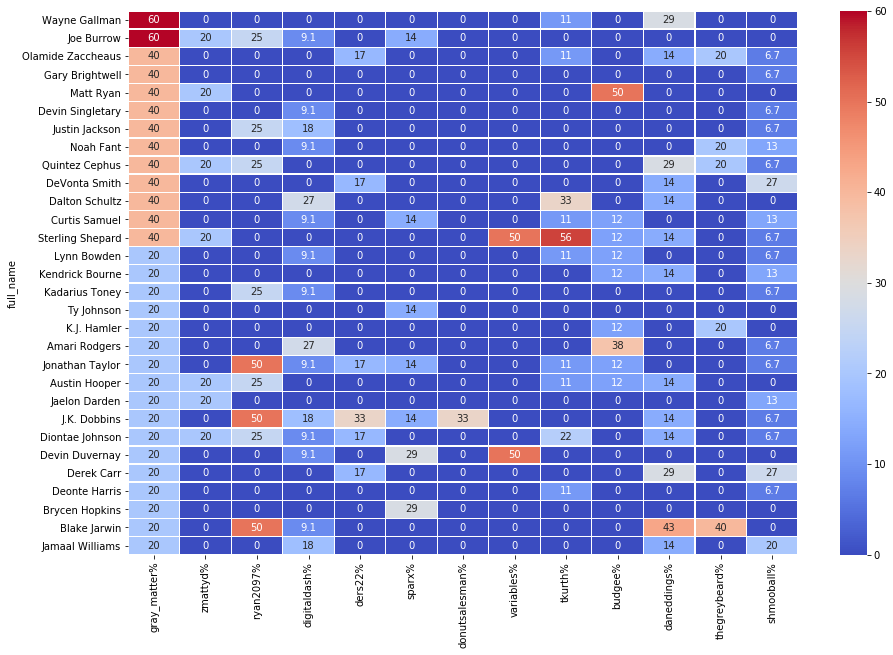

In [36]:
plt.rcParams['figure.figsize'] = (15, 10)
# pyplot.figure(figsize=(15, 10)) # width and height in inches

sns_heat = sns.heatmap(df_pct, cmap='coolwarm', linewidth=0.4, annot=True,label='big')

In [37]:
sns_heat.figure.savefig(f"C:\\Users\\grayson\\Downloads\{USER_NAME}_{LEAGUE_NAME}_ownership.pdf", dpi=300)

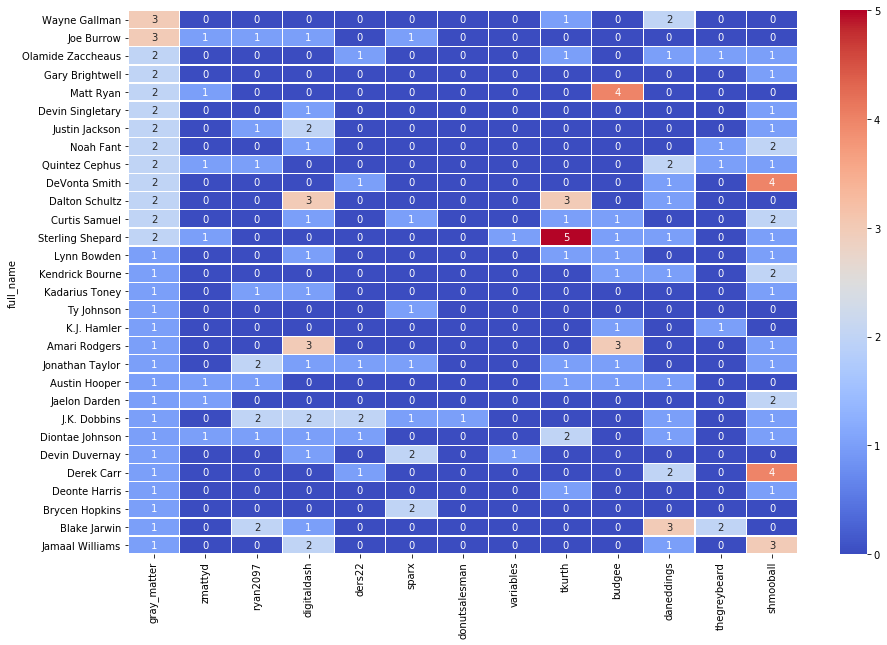

In [38]:
sns.heatmap(df_cnt, cmap='coolwarm', linewidth=0.4, annot=True)

In [39]:
p1.savefig('C:\\Users\\grayson\\Downloads\SuperN1ntend0_ownership.tiff')

NameError: name 'p1' is not defined